# RAG System with Feedback Loop: Enhancing Retrieval and Response Quality

## Overview

This system implements a Retrieval-Augmented Generation (RAG) approach with an integrated feedback loop. It aims to improve the quality and relevance of responses over time by incorporating user feedback and dynamically adjusting the retrieval process.

## Motivation

Traditional RAG systems can sometimes produce inconsistent or irrelevant responses due to limitations in the retrieval process or the underlying knowledge base. By implementing a feedback loop, we can:

1. Continuously improve the quality of retrieved documents
2. Enhance the relevance of generated responses
3. Adapt the system to user preferences and needs over time

## Key Components

1. **PDF Content Extraction**: Extracts text from PDF documents
2. **Vectorstore**: Stores and indexes document embeddings for efficient retrieval
3. **Retriever**: Fetches relevant documents based on user queries
4. **Language Model**: Generates responses using retrieved documents
5. **Feedback Collection**: Gathers user feedback on response quality and relevance
6. **Feedback Storage**: Persists user feedback for future use
7. **Relevance Score Adjustment**: Modifies document relevance based on feedback
8. **Index Fine-tuning**: Periodically updates the vectorstore using accumulated feedback

![feedback loop.png](<attachment:feedback loop.png>)

## Method Details

### 1. Initial Setup
- The system reads PDF content and creates a vectorstore
- A retriever is initialized using the vectorstore
- A language model (LLM) is set up for response generation

### 2. Query Processing
- When a user submits a query, the retriever fetches relevant documents
- The LLM generates a response based on the retrieved documents

### 3. Feedback Collection
- The system collects user feedback on the response's relevance and quality
- Feedback is stored in a JSON file for persistence

### 4. Relevance Score Adjustment
- For subsequent queries, the system loads previous feedback
- An LLM evaluates the relevance of past feedback to the current query
- Document relevance scores are adjusted based on this evaluation

### 5. Retriever Update
- The retriever is updated with the adjusted document scores
- This ensures that future retrievals benefit from past feedback

### 6. Periodic Index Fine-tuning
- At regular intervals, the system fine-tunes the index
- High-quality feedback is used to create additional documents
- The vectorstore is updated with these new documents, improving overall retrieval quality

## Benefits of this Approach

1. **Continuous Improvement**: The system learns from each interaction, gradually enhancing its performance.
2. **Personalization**: By incorporating user feedback, the system can adapt to individual or group preferences over time.
3. **Increased Relevance**: The feedback loop helps prioritize more relevant documents in future retrievals.
4. **Quality Control**: Low-quality or irrelevant responses are less likely to be repeated as the system evolves.
5. **Adaptability**: The system can adjust to changes in user needs or document contents over time.

## Conclusion

This RAG system with a feedback loop represents a significant advancement over traditional RAG implementations. By continuously learning from user interactions, it offers a more dynamic, adaptive, and user-centric approach to information retrieval and response generation. This system is particularly valuable in domains where information accuracy and relevance are critical, and where user needs may evolve over time.

While the implementation adds complexity compared to a basic RAG system, the benefits in terms of response quality and user satisfaction make it a worthwhile investment for applications requiring high-quality, context-aware information retrieval and generation.
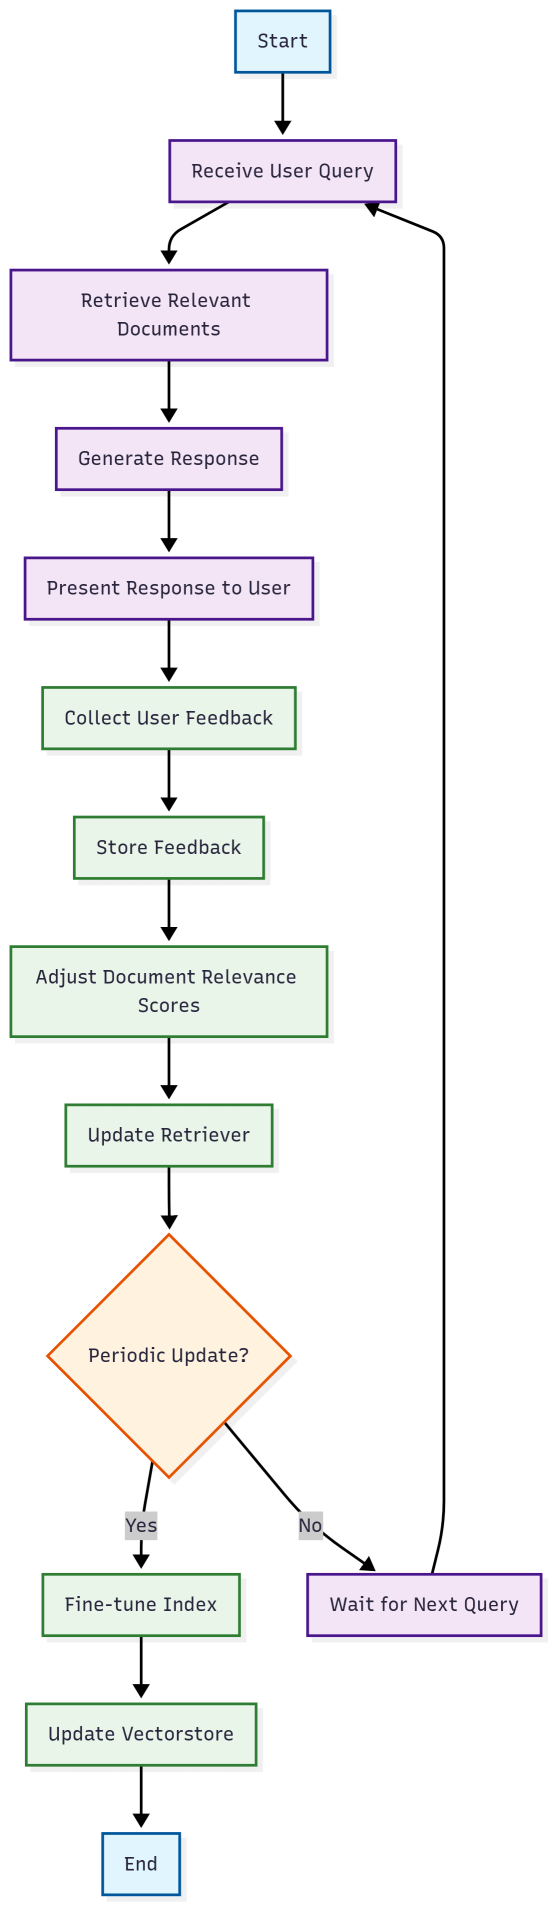

# Package Installation and Imports

The cell below installs all necessary packages required to run this notebook.


In [ ]:
# Install required packages for the RAG system
# langchain: Framework for building LLM applications
# langchain-openai: OpenAI integration for LangChain
# langchain-community: Community components for LangChain
# pypdf: Library for reading PDF files
# chromadb: Vector database for storing embeddings
# openai: OpenAI API client
!pip install langchain langchain-openai langchain-community pypdf chromadb openai

In [ ]:
import os

# Optional: Set up LangSmith tracking to monitor your LangChain applications
# This helps you see what's happening behind the scenes in your RAG system
os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = '<your-langsmith-api-key>'  # Replace with your actual API key

# Set your OpenAI API key here - this is required for embeddings and LLM calls
os.environ["OPENAI_API_KEY"] = "<your-api-key>"  # Replace with your actual OpenAI API key

In [ ]:
# Import all necessary libraries for the RAG system
from langchain.prompts import PromptTemplate  # For creating structured prompts
from langchain_openai import OpenAIEmbeddings, ChatOpenAI  # OpenAI models for embeddings and chat
from pydantic import BaseModel, Field  # For data validation and structure
from langchain.document_loaders import PyPDFLoader  # For loading PDF documents
from langchain.text_splitter import RecursiveCharacterTextSplitter  # For splitting large texts into chunks
from langchain.vectorstores import Chroma  # Vector database for storing document embeddings
from langchain.chains import RetrievalQA  # Pre-built chain for question-answering with retrieval
from langchain.schema import Document  # Document class for LangChain
import json  # For handling JSON data (feedback storage)
from typing import List, Dict, Any  # Type hints for better code documentation

# Define the path where your PDF files are stored
# Update this path to match your local directory structure
source_path = r"<you-base-path>"

# Create a list of PDF loaders - each loader handles one PDF file
# These are machine learning lecture PDFs that will serve as our knowledge base
loaders = [
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture01.pdf")),
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture02.pdf")),
    PyPDFLoader(os.path.join(source_path, "MachineLearning-Lecture03.pdf"))
]

# Initialize an empty list to store all document pages
docs = []

# Load each PDF and extract all pages
for i, loader in enumerate(loaders):
    print(f"Loading PDF {i+1}/{len(loaders)}...")  # Progress indicator
    # Each PDF might have multiple pages, so we extend (not append) the list
    # loader.load() returns a list of Document objects, one per page
    docs.extend(loader.load())

# Create a text splitter to break large documents into smaller, manageable chunks
# This is important because LLMs have token limits and smaller chunks improve retrieval accuracy
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,      # Each chunk will be approximately 1500 characters long
    chunk_overlap=150     # 150 characters overlap between chunks to maintain context
)

# Split all documents into chunks
# This converts our list of full documents into a list of smaller text chunks
splits = text_splitter.split_documents(docs)

# Initialize the OpenAI embeddings model
# This will convert text chunks into numerical vectors for similarity search
embedding = OpenAIEmbeddings()

# Define where to save the vector database locally
persist_directory = 'docs/chroma/'

# Create a Chroma vector database from our document chunks
# This stores the text chunks along with their vector embeddings
vectorstore = Chroma.from_documents(
    documents=splits,              # Our document chunks
    embedding=embedding,           # The embedding model to convert text to vectors
    persist_directory=persist_directory  # Where to save the database locally
)

# Create a retriever from the vectorstore
# This will be used to find relevant documents for user queries
retriever = vectorstore.as_retriever()

# Initialize the language model for generating responses
# Using GPT-4o-mini for cost efficiency while maintaining good performance
llm = ChatOpenAI(model="gpt-4o-mini", max_tokens=4000, temperature=0)  # type: ignore

# Create a Question-Answering chain that combines retrieval and generation
# This chain will: 1) retrieve relevant docs, 2) generate answer using those docs
qa_chain = RetrievalQA.from_chain_type(llm, retriever=retriever)

print(f"Successfully loaded {len(docs)} documents and created {len(splits)} chunks")
print(f"Vector database created with {vectorstore._collection.count()} embeddings")

## Feedback Collection Functions

These functions handle collecting, storing, and loading user feedback about the RAG system's responses.

In [ ]:
def get_user_feedback(query, response, relevance, quality, comments=""):
    """
    Create a structured feedback dictionary to store user evaluations.
    
    Args:
        query (str): The original user question
        response (str): The system's generated answer
        relevance (int): User rating of how relevant the answer was (1-5 scale)
        quality (int): User rating of answer quality (1-5 scale)
        comments (str): Optional additional feedback comments
    
    Returns:
        dict: Structured feedback data ready for storage
    """
    return {
        "query": query,                    # Store the original question
        "response": response,              # Store the system's answer
        "relevance": int(relevance),       # Convert to integer for consistency
        "quality": int(quality),           # Convert to integer for consistency
        "comments": comments               # Store any additional feedback
    }

In [ ]:
def store_feedback(feedback, file_path="data/feedback_data.json"):
    """
    Save user feedback to a JSON file for persistence across sessions.
    Each feedback entry is stored as a separate line (JSONL format).
    
    Args:
        feedback (dict): The feedback dictionary to store
        file_path (str): Path where feedback file should be saved
    """
    # Create the directory structure if it doesn't exist
    # This ensures we can write to the file even if the folder is missing
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    # Create an empty file if it doesn't exist yet
    # This prevents FileNotFoundError on first run
    if not os.path.exists(file_path):
        with open(file_path, "w", encoding="utf-8") as f:
            pass  # Just create the empty file

    # Append the new feedback to the file
    # We use append mode ('a') to keep all previous feedback
    with open(file_path, "a", encoding="utf-8") as f:
        # Write feedback as JSON on a single line
        json.dump(feedback, f, ensure_ascii=False)
        f.write("\n")  # Add newline to separate entries
    
    print(f"Feedback stored successfully to {file_path}")

In [ ]:
def load_feedback_data(file_path="data/feedback_data.json"):
    """
    Load all stored feedback from the JSON file.
    
    Args:
        file_path (str): Path to the feedback file
    
    Returns:
        list: List of all feedback dictionaries
    """
    feedback_data = []  # Initialize empty list to store feedback
    
    try:
        # Try to open and read the feedback file
        with open(file_path, "r", encoding="utf-8") as f:
            # Read each line as a separate JSON object
            for line_number, line in enumerate(f, 1):
                try:
                    # Skip empty lines
                    if line.strip():
                        # Parse the JSON data and add to our list
                        feedback_data.append(json.loads(line.strip()))
                except json.JSONDecodeError as e:
                    print(f"Warning: Could not parse line {line_number}: {e}")
                    continue  # Skip malformed lines
                    
    except FileNotFoundError:
        # If file doesn't exist yet, that's okay - we're starting fresh
        print("No feedback data file found. Starting with empty feedback.")
    
    print(f"Loaded {len(feedback_data)} feedback entries")
    return feedback_data

## Relevance Score Adjustment Function

This is one of the core functions that makes our RAG system adaptive. It uses past feedback to adjust how relevant each document appears for new queries.

In [ ]:
# Define a Pydantic model to ensure LLM returns properly structured responses
class Response(BaseModel):
    answer: str = Field(..., title="The answer to the question. The options can be only 'Yes' or 'No'")

def adjust_relevance_scores(query: str, docs: List[Any], feedback_data: List[Dict[str, Any]]) -> List[Any]:
    """
    Adjust document relevance scores based on historical user feedback.
    
    This function:
    1. Takes the current user query and retrieved documents
    2. Looks at all past feedback to find relevant experiences
    3. Uses an LLM to determine if past feedback applies to current documents
    4. Adjusts document scores based on feedback quality
    5. Returns re-ranked documents
    
    Args:
        query (str): The current user question
        docs (List[Any]): List of (document, similarity_score) tuples from retrieval
        feedback_data (List[Dict]): All historical feedback data
    
    Returns:
        List[Document]: Re-ranked documents with adjusted relevance scores
    """
    
    # Create a prompt template for the LLM to evaluate feedback relevance
    # This prompt asks the LLM to determine if past feedback is relevant to current context
    relevance_prompt = PromptTemplate(
        input_variables=["query", "feedback_query", "doc_content", "feedback_response"],  # type: ignore
        template="""
        Determine if the following feedback response is relevant to the current query and document content.
        You are also provided with the feedback's original query for context.
        
        Current query: {query}
        Original feedback query: {feedback_query}
        Document content (first 1000 chars): {doc_content}
        Feedback response: {feedback_response}
        
        Consider the feedback relevant if:
        - The topics are similar between current and feedback queries
        - The document content relates to the feedback response
        - The feedback could inform the quality of this document for the current query
        
        Is this feedback relevant? Respond with only 'Yes' or 'No'.
        """
    )
    
    # Initialize a more capable LLM for relevance evaluation
    # Using GPT-4o for better reasoning about relevance
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o", max_tokens=4000)  # type: ignore

    # Create a chain that combines our prompt with structured output
    # This ensures we get back a properly formatted Yes/No answer
    relevance_chain = relevance_prompt | llm.with_structured_output(Response)

    final_docs = []  # List to store documents with adjusted scores
    
    # Process each retrieved document
    for doc, score in docs:
        # Store the original similarity score in document metadata
        doc.metadata["original_score"] = score
        doc.metadata["relevance_score"] = score  # Start with original score
        
        relevant_feedback = []  # Collect feedback relevant to this document
        
        # Check each piece of historical feedback for relevance
        for feedback in feedback_data:
            # Prepare input for the LLM relevance checker
            input_data = {
                "query": query,
                "feedback_query": feedback['query'],
                "doc_content": doc.page_content[:1000],  # Limit to first 1000 chars to stay within token limits
                "feedback_response": feedback['response']
            }
            
            # Ask the LLM if this feedback is relevant
            try:
                result = relevance_chain.invoke(input_data).answer  # type: ignore
                
                # If LLM says the feedback is relevant, include it
                if result.lower() == 'yes':
                    relevant_feedback.append(feedback)
                    print(f"Found relevant feedback for document: {feedback['query'][:50]}...")
                    
            except Exception as e:
                print(f"Error checking relevance: {e}")
                continue
        
        # Adjust the relevance score based on relevant feedback
        if relevant_feedback:
            # Calculate average relevance score from feedback (1-5 scale)
            avg_relevance = sum(f['relevance'] for f in relevant_feedback) / len(relevant_feedback)
            
            # Calculate average quality score from feedback (1-5 scale)
            avg_quality = sum(f['quality'] for f in relevant_feedback) / len(relevant_feedback)
            
            # Combine relevance and quality for final adjustment
            feedback_score = (avg_relevance + avg_quality) / 2
            
            # Adjust the original similarity score
            # Score > 3 (neutral) boosts the document, score < 3 reduces it
            adjustment_factor = (feedback_score / 3.0)  # 3 is neutral on 1-5 scale
            doc.metadata['relevance_score'] = score * adjustment_factor
            
            # Store feedback info in metadata for debugging
            doc.metadata['feedback_count'] = len(relevant_feedback)
            doc.metadata['avg_feedback_score'] = feedback_score
            
            print(f"Adjusted document score from {score:.3f} to {doc.metadata['relevance_score']:.3f} "
                  f"based on {len(relevant_feedback)} feedback entries (avg score: {feedback_score:.2f})")
        
        final_docs.append(doc)
    
    # Re-rank documents based on adjusted relevance scores
    # Sort in descending order (highest relevance first)
    sorted_docs = sorted(final_docs, key=lambda x: x.metadata['relevance_score'], reverse=True)
    
    print(f"\nDocument ranking after feedback adjustment:")
    for i, doc in enumerate(sorted_docs[:3]):  # Show top 3
        original = doc.metadata.get('original_score', 0)
        adjusted = doc.metadata.get('relevance_score', 0)
        print(f"{i+1}. Score: {original:.3f} -> {adjusted:.3f} | {doc.page_content[:100]}...")
    
    return sorted_docs

## Example: How Relevance Score Adjustment Works

Let's see the relevance score adjustment in action with a concrete example.

In [ ]:
# EXAMPLE: Demonstrating Relevance Score Adjustment
print("=== EXAMPLE: Relevance Score Adjustment ===")

# Step 1: Create some sample feedback data to simulate past interactions
sample_feedback = [
    {
        "query": "What is supervised learning?",
        "response": "Supervised learning is a type of machine learning where algorithms learn from labeled training data...",
        "relevance": 5,
        "quality": 4,
        "comments": "Very helpful explanation"
    },
    {
        "query": "Explain neural networks",
        "response": "Neural networks are computing systems inspired by biological neural networks...",
        "relevance": 3,
        "quality": 2,
        "comments": "Too technical, hard to understand"
    },
    {
        "query": "What are the types of machine learning?",
        "response": "The main types are supervised, unsupervised, and reinforcement learning...",
        "relevance": 5,
        "quality": 5,
        "comments": "Perfect answer, covered all types clearly"
    }
]

# Step 2: Test with a new query similar to our feedback
test_query = "What is machine learning and its types?"

print(f"\nTesting query: '{test_query}'")
print("\nStep 1: Getting initial document retrieval...")

# Get initial retrieval results (documents with similarity scores)
docs_with_scores = retriever.vectorstore.similarity_search_with_score(test_query, k=5)

print(f"Retrieved {len(docs_with_scores)} documents with original scores:")
for i, (doc, score) in enumerate(docs_with_scores):
    print(f"{i+1}. Original Score: {score:.3f} | Content: {doc.page_content[:100]}...")

print("\nStep 2: Applying feedback-based relevance adjustment...")

# Apply relevance score adjustment using our sample feedback
adjusted_docs = adjust_relevance_scores(test_query, docs_with_scores, sample_feedback)

print("\nStep 3: Comparison of before and after ranking:")
print("\nBEFORE (original similarity scores):")
for i, (doc, score) in enumerate(docs_with_scores[:3]):
    print(f"{i+1}. Score: {score:.3f}")

print("\nAFTER (feedback-adjusted scores):")
for i, doc in enumerate(adjusted_docs[:3]):
    original = doc.metadata.get('original_score', 0)
    adjusted = doc.metadata.get('relevance_score', 0)
    feedback_count = doc.metadata.get('feedback_count', 0)
    print(f"{i+1}. Score: {original:.3f} -> {adjusted:.3f} (based on {feedback_count} feedback entries)")

print("\nExplanation:")
print("- Documents get boosted if past feedback was positive (relevance/quality > 3)")
print("- Documents get penalized if past feedback was negative (relevance/quality < 3)")
print("- Only feedback deemed relevant by the LLM affects the scores")
print("- This helps prioritize documents that previously led to good responses")

## Index Fine-tuning Function

This function periodically rebuilds the vector index to include high-quality question-answer pairs from user feedback.

In [ ]:
def fine_tune_index(feedback_data: List[Dict[str, Any]], base_docs: List[Any], quality_threshold: int = 4) -> Any:
    """
    Rebuild the vectorstore to include high-quality feedback as additional knowledge.
    
    This function:
    1. Filters feedback to find high-quality question-answer pairs
    2. Converts good feedback into new "documents"
    3. Combines original documents with feedback-derived documents
    4. Rebuilds the entire vectorstore with enhanced knowledge
    
    Args:
        feedback_data (List[Dict]): All collected feedback
        base_docs (List[Document]): Original document chunks
        quality_threshold (int): Minimum score for feedback to be included (default: 4)
    
    Returns:
        Chroma: New vectorstore with enhanced knowledge base
    """
    
    print(f"Starting index fine-tuning with {len(feedback_data)} feedback entries...")
    
    # Step 1: Filter for high-quality feedback
    # We only want to include feedback where both relevance and quality are high
    good_responses = [
        f for f in feedback_data 
        if f['relevance'] >= quality_threshold and f['quality'] >= quality_threshold
    ]
    
    print(f"Found {len(good_responses)} high-quality feedback entries (threshold: {quality_threshold})")
    
    # Step 2: Convert high-quality feedback into new "documents"
    additional_docs = []
    for i, feedback in enumerate(good_responses):
        # Combine the question and answer into a single document
        # This creates a Q&A knowledge base from user interactions
        combined_text = f"Question: {feedback['query']}\n\nAnswer: {feedback['response']}"
        
        # Create a new Document object with metadata
        new_doc = Document(
            page_content=combined_text,
            metadata={
                "source": "user_feedback",  # Mark this as feedback-derived
                "feedback_id": i,
                "relevance_score": feedback['relevance'],
                "quality_score": feedback['quality'],
                "type": "qa_pair"  # Distinguish from original documents
            }
        )
        additional_docs.append(new_doc)
        
        print(f"Added Q&A pair {i+1}: {feedback['query'][:60]}...")

    # Step 3: Combine original documents with feedback-derived documents
    all_docs = base_docs + additional_docs
    
    print(f"\nCombining knowledge base:")
    print(f"- Original documents: {len(base_docs)}")
    print(f"- Feedback-derived documents: {len(additional_docs)}")
    print(f"- Total documents: {len(all_docs)}")

    # Step 4: Rebuild the vectorstore with enhanced knowledge
    # Create new embeddings for all documents (original + feedback)
    embedding = OpenAIEmbeddings()
    persist_directory = 'docs/chroma_enhanced/'  # Use different directory for enhanced version
    
    print("\nRebuilding vectorstore with enhanced knowledge base...")
    
    # Create the enhanced vectorstore
    new_vectorstore = Chroma.from_documents(
        documents=all_docs,
        embedding=embedding,
        persist_directory=persist_directory
    )
    
    # Persist the vectorstore to disk for future use
    new_vectorstore.persist()
    
    print(f"Enhanced vectorstore created with {new_vectorstore._collection.count()} total embeddings")
    print(f"Vectorstore saved to: {persist_directory}")
    
    return new_vectorstore

## Example: How Index Fine-tuning Works

Let's demonstrate the fine-tuning process with concrete examples.

In [ ]:
# EXAMPLE: Demonstrating Index Fine-tuning
print("=== EXAMPLE: Index Fine-tuning Process ===")

# Step 1: Create comprehensive sample feedback data
sample_feedback_for_tuning = [
    {
        "query": "What is the difference between supervised and unsupervised learning?",
        "response": "Supervised learning uses labeled data to train models, while unsupervised learning finds patterns in unlabeled data. Supervised learning includes classification and regression, while unsupervised includes clustering and dimensionality reduction.",
        "relevance": 5,
        "quality": 5,
        "comments": "Excellent explanation with clear distinctions"
    },
    {
        "query": "How does gradient descent work?",
        "response": "Gradient descent is an optimization algorithm that iteratively adjusts model parameters to minimize the cost function by moving in the direction of steepest descent.",
        "relevance": 4,
        "quality": 4,
        "comments": "Good technical explanation"
    },
    {
        "query": "What is overfitting?",
        "response": "Overfitting occurs when a model performs well on training data but poorly on new, unseen data. It happens when the model is too complex and learns noise rather than patterns.",
        "relevance": 5,
        "quality": 4,
        "comments": "Clear and practical explanation"
    },
    {
        "query": "Explain deep learning",
        "response": "Very technical explanation that was hard to follow...",
        "relevance": 2,
        "quality": 2,
        "comments": "Too complicated, needs simpler explanation"
    }
]

print(f"\nInput: {len(sample_feedback_for_tuning)} feedback entries")
for i, fb in enumerate(sample_feedback_for_tuning):
    print(f"{i+1}. Query: {fb['query'][:50]}... | Relevance: {fb['relevance']} | Quality: {fb['quality']}")

print("\nStep 1: Filtering high-quality feedback (threshold: 4)...")

# Show the filtering process
quality_threshold = 4
high_quality_feedback = [
    f for f in sample_feedback_for_tuning 
    if f['relevance'] >= quality_threshold and f['quality'] >= quality_threshold
]

print(f"Filtered to {len(high_quality_feedback)} high-quality entries:")
for i, fb in enumerate(high_quality_feedback):
    print(f"{i+1}. {fb['query'][:60]}... (R:{fb['relevance']}, Q:{fb['quality']})")

print("\nStep 2: Converting feedback to documents...")

# Show how feedback becomes documents
for i, fb in enumerate(high_quality_feedback[:2]):  # Show first 2 examples
    combined_text = f"Question: {fb['query']}\n\nAnswer: {fb['response']}"
    print(f"\nNew Document {i+1}:")
    print(f"Content: {combined_text[:200]}...")
    print(f"Metadata: source=user_feedback, relevance={fb['relevance']}, quality={fb['quality']}")

print("\nStep 3: Simulating vectorstore enhancement...")

# Get current vectorstore stats
original_count = vectorstore._collection.count() if hasattr(vectorstore, '_collection') else len(splits)
enhanced_count = original_count + len(high_quality_feedback)

print(f"Before fine-tuning: {original_count} documents")
print(f"Adding: {len(high_quality_feedback)} Q&A pairs from feedback")
print(f"After fine-tuning: {enhanced_count} documents (projected)")

print("\nStep 4: Benefits of fine-tuning:")
print("- User-validated Q&A pairs become searchable knowledge")
print("- Future similar queries will find these proven good answers")
print("- System learns from successful interactions")
print("- Knowledge base becomes more comprehensive over time")

enhanced_vectorstore = fine_tune_index(sample_feedback_for_tuning, splits)